<a href="https://colab.research.google.com/github/chickfilaman51/SAM2-VideoTracking/blob/main/Krish_sam2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Segment Videos with Segment Anything 2 (SAM2)

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/facebookresearch/segment-anything-2)

Segment Anything Model 2 (SAM 2) is a foundation model designed to address promptable visual segmentation in both images and videos. The model extends its functionality to video by treating images as single-frame videos. Its design, a simple transformer architecture with streaming memory, enables real-time video processing. A model-in-the-loop data engine, which enhances the model and data through user interaction, was built to collect the SA-V dataset, the largest video segmentation dataset to date. SAM 2, trained on this extensive dataset, delivers robust performance across diverse tasks and visual domains.

![segment anything model](https://media.roboflow.com/notebooks/examples/segment-anything-model-2-paper.jpg)

This notebook is an extension of the official [notebook](https://github.com/facebookresearch/segment-anything-2/blob/main/notebooks/image_predictor_example.ipynb) prepared by Meta AI.

## Complementary materials

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-segment-images-with-sam-2.ipynb)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/what-is-segment-anything-2)

We recommend that you follow along in this notebook while reading the blog post on Segment Anything Model 2 (SAM2).

[![SAM2 blogpost](https://media.roboflow.com/notebooks/examples/blog-what-is-sam-2.png)](https://blog.roboflow.com/what-is-segment-anything-2)

## Setup

### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi
#testing comments in connecting

Wed Jul 31 19:14:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)
! git clone link/to/your/repo

HOME: /content


### Install SAM2 and dependencies

In [ ]:
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd {HOME}/segment-anything-2
!pip install -e . -q
!python setup.py build_ext --inplace

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 302, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 302 (delta 9), reused 7 (delta 7), pack-reused 280
Receiving objects: 100% (302/302), 42.92 MiB | 9.72 MiB/s, done.
Resolving deltas: 100% (18/18), done.
/content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 158.9 kB/s eta 0:00:00
  Building editabl

In [ ]:
!pip install -q supervision[assets] jupyter_bbox_widget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.2 MB/s eta 0:00:00


### Download SAM2 checkpoints

**NOTE:** SAM2 is available in 4 different model sizes ranging from the lightweight "sam2_hiera_tiny" (38.9M parameters) to the more powerful "sam2_hiera_large" (224.4M parameters).

In [ ]:
!mkdir -p {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

### Imports

In [ ]:
import cv2
import torch
import base64

import numpy as np
import supervision as sv

from pathlib import Path
from supervision.assets import download_assets, VideoAssets
from sam2.build_sam import build_sam2_video_predictor

**NOTE:** This code enables mixed-precision computing for faster deep learning. It uses bfloat16 for most calculations and, on newer NVIDIA GPUs, leverages TensorFloat-32 (TF32) for certain operations to further boost performance.

In [ ]:
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

## Load model

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"{HOME}/checkpoints/sam2_hiera_large.pt"
CONFIG = "sam2_hiera_l.yaml"

sam2_model = build_sam2_video_predictor(CONFIG, CHECKPOINT)

## Preprocess video

### Download video and split it into frames

**NOTE:** SAM2 assumee that the video is stored as a list of JPEG frames with filenames like `<frame_index>.jpg`. Let's start by downloading a sample video, splitting it into frames, and saving them to disk.

In [ ]:
HOME = '/content'
SCALE_FACTOR = 0.5
SOURCE_VIDEO = '/content/mouseVidHide.mp4'
SOURCE_FRAMES = Path(HOME) / Path(SOURCE_VIDEO).stem
SOURCE_FRAMES.mkdir(parents=True, exist_ok=True)
cap = cv2.VideoCapture(SOURCE_VIDEO)

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

frames_generator = sv.get_video_frames_generator(SOURCE_VIDEO, start=0, end=total_frames) # change
images_sink = sv.ImageSink(
    target_dir_path=SOURCE_FRAMES.as_posix(),
    overwrite=True,
    image_name_pattern="{:05d}.jpeg"
)

with images_sink:
    for frame in frames_generator:
        frame = sv.scale_image(frame, SCALE_FACTOR)
        images_sink.save_image(frame)

SOURCE_IMAGE = SOURCE_FRAMES / "00001.jpeg"
TARGET_VIDEO = Path(HOME) / f"{Path(SOURCE_VIDEO).stem}-result.mp4"

### Initialize the inference state

**NOTE:** SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an inference state on this video. During initialization, it loads all the JPEG frames in `video_path` and stores their pixels in `inference_state` (as shown in the progress bar below).

In [ ]:
inference_state = sam2_model.init_state(video_path=SOURCE_FRAMES.as_posix())

frame loading (JPEG): 100%|██████████| 447/447 [00:14<00:00, 31.59it/s]


**NOTE:** If you have run any previous tracking using this inference_state, please reset it first via reset_state. (The cell below is just for illustration; it's not needed to call reset_state here as this inference_state is just freshly initialized above.)

In [ ]:
sam2_model.reset_state(inference_state)

### Prompting with points

In [ ]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

**NOTE:** To get started, let's try to segment the ball. Execute cell below and use your mouse to **draw point** on the image 👇

In [ ]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(SOURCE_IMAGE)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [ ]:
widget.bboxes

[{'x': 287, 'y': 160, 'width': 0, 'height': 0, 'label': ''}]

In [ ]:
default_box = [{'x': 224, 'y': 171, 'width': 0, 'height': 0, 'label': ''}]

boxes = widget.bboxes if widget.bboxes else default_box
points = np.array([
    [
        box['x'],
        box['y']
    ] for box in boxes
], dtype=np.float32)
labels = np.ones(len(points))

**NOTE:** Here we make a positive click at `(x, y) = (713, 306)` with label `1`, by sending their coordinates and labels into the add_new_points API. Label `1` indicates a positive click (to add a region) while label `0` indicates a negative click (to remove a region).

### Single frame inference

In [ ]:
FRAME_IDX = 0
OBJECT_ID = 1

_, object_ids, mask_logits = sam2_model.add_new_points(
    inference_state=inference_state,
    frame_idx=FRAME_IDX,
    obj_id=OBJECT_ID,
    points=points,
    labels=labels,
)

masks = (mask_logits[0] > 0.0).cpu().numpy()

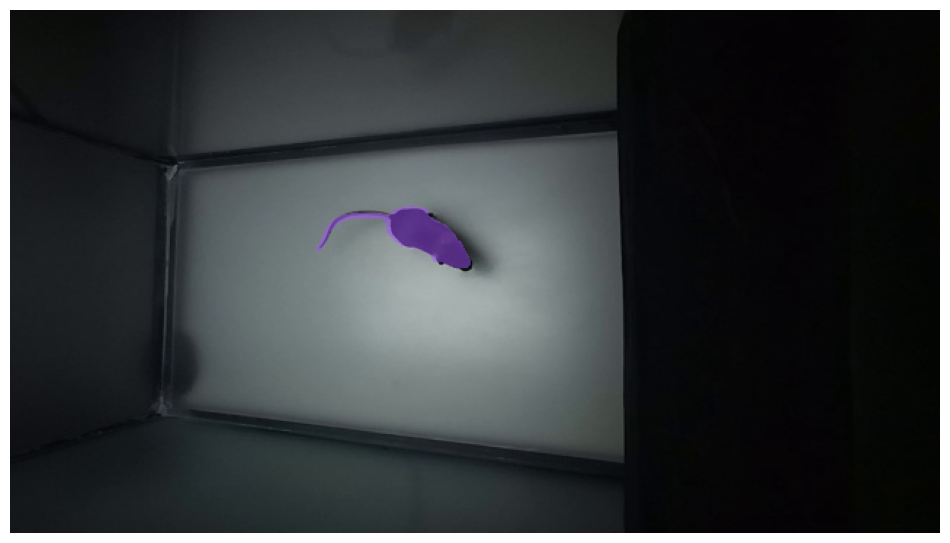

In [ ]:
image_bgr = cv2.imread(SOURCE_IMAGE)
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks.astype(bool)
)

segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_image(segmented_image)

### Video inference

**NOTE:** To get the masklet throughout the entire video, we propagate the prompts using the `propagate_in_video` API.

In [ ]:
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO)
video_info.width = int(video_info.width * SCALE_FACTOR)
video_info.height = int(video_info.height * SCALE_FACTOR)
coordinates = []

frame_paths = sorted(sv.list_files_with_extensions(SOURCE_FRAMES.as_posix(), extensions=["jpeg"]))

with sv.VideoSink(TARGET_VIDEO.as_posix(), video_info=video_info) as sink:
    for frame_idx, object_ids, mask_logits in sam2_model.propagate_in_video(inference_state):
        frame_path = frame_paths[frame_idx]
        frame = cv2.imread(frame_path)
        masks = (mask_logits[0] > 0.0).cpu().numpy()

        detections = sv.Detections(
            xyxy=sv.mask_to_xyxy(masks=masks),
            mask=masks.astype(bool)
        )
        print(detections.xyxy)
        coordinates.append(detections.xyxy)
        annotated_frame = mask_annotator.annotate(scene=frame.copy(), detections=detections)
        sink.write_frame(annotated_frame)

propagate in video: 100%|██████████| 447/447 [08:06<00:00,  1.09s/it]


In [ ]:
import numpy as np


flatten_cords = np.array(coordinates).flatten().reshape(-1,4)
print(flatten_cords)

import numpy as np

def point_line_distance(point, line_start, line_end):
    """Calculate the distance from a point to a line segment."""
    x, y = point
    x1, y1 = line_start
    x2, y2 = line_end

    A = x - x1
    B = y - y1
    C = x2 - x1
    D = y2 - y1

    dot = A * C + B * D
    len_sq = C * C + D * D
    param = dot / len_sq if len_sq != 0 else -1

    if param < 0:
        xx = x1
        yy = y1
    elif param > 1:
        xx = x2
        yy = y2
    else:
        xx = x1 + param * C
        yy = y1 + param * D

    dx = x - xx
    dy = y - yy
    return np.sqrt(dx * dx + dy * dy)



#WALL_THRESHOLD = 1  # Distance from wall to consider "hugging"
MOVEMENT_THRESHOLD = 2  # Distance to consider movement
HIDDEN_AREA_THRESHOLD = 5  # Minimum area to consider the object as visible


def is_hidden(bbox):
    """Determine if the object is hidden based on the area of the bounding box."""
    x_min, y_min, x_max, y_max = bbox
    area = (x_max - x_min) * (y_max - y_min)
    return area < HIDDEN_AREA_THRESHOLD

def closest_point_on_line(point, line_start, line_end):
    """Find the closest point on a line segment to the given point."""
    x, y = point
    x1, y1 = line_start
    x2, y2 = line_end

    # Line segment vector
    line_vec = np.array([x2 - x1, y2 - y1])
    point_vec = np.array([x - x1, y - y1])

    # Project point_vec onto line_vec
    line_len_sq = np.dot(line_vec, line_vec)
    if line_len_sq == 0:
        return (x1, y1)

    proj = np.dot(point_vec, line_vec) / line_len_sq
    proj = np.clip(proj, 0, 1)

    closest_point = np.array([x1, y1]) + proj * line_vec
    return tuple(closest_point)

def is_point_within_bbox(x, y, bbox):
    """Check if a point (x, y) is inside the bounding box defined by bbox."""
    x_min, y_min, x_max, y_max = bbox
    return x_min <= x <= x_max and y_min <= y <= y_max

def is_hugging_wall(bbox):
    """Determine if the bounding box is hugging the wall or if closest point is within the bounding box."""
    x_min, y_min, x_max, y_max = bbox
    bbox_center = ((x_min + x_max) / 2, (y_min + y_max) / 2)

    # Check distance to each edge
    top_edge = (TOP_LEFT, TOP_RIGHT)
    bottom_edge = (BOTTOM_LEFT, BOTTOM_RIGHT)
    left_edge = (TOP_LEFT, BOTTOM_LEFT)
    right_edge = (TOP_RIGHT, BOTTOM_RIGHT)

    edges = [top_edge, bottom_edge, left_edge, right_edge]

    for edge in edges:
        start, end = edge
        closest_point = closest_point_on_line(bbox_center, start, end)
        if is_point_within_bbox(*closest_point, bbox):
            return True

    return False


def is_moving(coord1, coord2):
    return np.linalg.norm(np.array(coord2[:2]) - np.array(coord1[:2])) > MOVEMENT_THRESHOLD


def is_standing(coord, previous_coord=None):
    """Determine if the object is standing still based on position stability."""
    if previous_coord is not None:
        # Calculate center of the bounding box for both current and previous coordinates
        x_center_current = (coord[0] + coord[2]) / 2
        y_center_current = (coord[1] + coord[3]) / 2
        x_center_previous = (previous_coord[0] + previous_coord[2]) / 2
        y_center_previous = (previous_coord[1] + previous_coord[3]) / 2

        # Calculate distance moved between frames
        distance_moved = np.linalg.norm([x_center_current - x_center_previous, y_center_current - y_center_previous])
        is_position_stable = distance_moved < MOVEMENT_THRESHOLD
    else:
        is_position_stable = True  # No previous coord to compare with

    return is_position_stable



def classify_motion(coordinates):
    motion_intervals = []
    start_frame = 0
    current_state = None
    previous_coord = None

    for i, coord in enumerate(coordinates):
        if is_hidden(coord):
            new_state = 'Hidden'
        elif is_hugging_wall(coord):
            new_state = 'Hugging Wall'
        elif is_standing(coord, previous_coord):
            new_state = 'Standing Still'
        else:
            new_state = 'Moving'

        if new_state != current_state:
            if current_state is not None:
                motion_intervals.append((start_frame, i-1, current_state))
            start_frame = i
            current_state = new_state

        previous_coord = coord  # Update previous coordinate

    # Append the last interval
    motion_intervals.append((start_frame, len(coordinates)-1, current_state))

    return motion_intervals

# Assuming flatten_cords is your 2D list of coordinates
flatten_cords = np.array(coordinates).flatten().reshape(-1, 4)
intervals = classify_motion(flatten_cords)

# Print intervals
for interval in intervals:
    print(f"Frames {interval[0]} to {interval[1]}: {interval[2]}")

[[211 135 316 177]
 [213 137 318 180]
 [212 137 319 180]
 [213 134 318 180]
 [212 133 315 180]
 [212 133 315 181]
 [213 132 314 183]
 [215 131 315 187]
 [217 130 318 188]
 [218 128 320 191]
 [220 127 323 195]
 [221 130 325 200]
 [224 137 328 206]
 [224 143 330 212]
 [225 144 333 219]
 [233 140 336 223]
 [244 136 338 227]
 [248 137 340 231]
 [249 139 343 234]
 [248 146 342 237]
 [247 151 342 240]
 [246 155 342 241]
 [248 156 342 241]
 [250 155 342 241]
 [251 155 342 240]
 [253 154 342 236]
 [253 155 342 232]
 [250 155 342 230]
 [250 156 342 228]
 [250 158 343 224]
 [250 157 344 222]
 [251 155 346 223]
 [252 154 349 221]
 [252 156 352 221]
 [253 156 355 223]
 [253 157 358 225]
 [254 159 363 228]
 [255 160 369 230]
 [253 162 376 233]
 [257 164 382 236]
 [266 164 388 238]
 [270 165 393 242]
 [274 169 397 246]
 [276 178 402 250]
 [276 182 407 254]
 [275 188 415 260]
 [278 191 420 264]
 [289 188 421 267]
 [301 183 422 271]
 [308 182 422 274]
 [314 181 422 277]
 [315 188 422 278]
 [320 191 42